In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import geopandas
import numpy as np
import os
import moviepy.video.io.ImageSequenceClip
from moviepy.editor import AudioFileClip

# delete existing files
for f in os.listdir("../Plots/Airports/"):
    os.remove(os.path.join("../Plots/Airports/", f))

# Load airport data

# data is from https://openflights.org/data#airlines
# removed '\N' values from the data + added column names
data = pd.read_csv('../Data/airports.csv', encoding='utf-8')

In [2]:
# Transform data

# subset data
data = data[['airport_id','city','country','latitude','longitude','altitude']]
# Remove rows with missing values
data = data.dropna()


# cut altitude into 300 bins with the same count

# note, since we can't use qcut due to duplicates, we'll cheat and give altitude a small random noise
data['altitude'] = data['altitude'] + np.random.uniform(-1,1,len(data))
data['altitude_cuts'] = pd.qcut(data['altitude'], q=300)

# categorize as unique integers
data['altitude_group'] = data['altitude_cuts'].astype('category').cat.codes

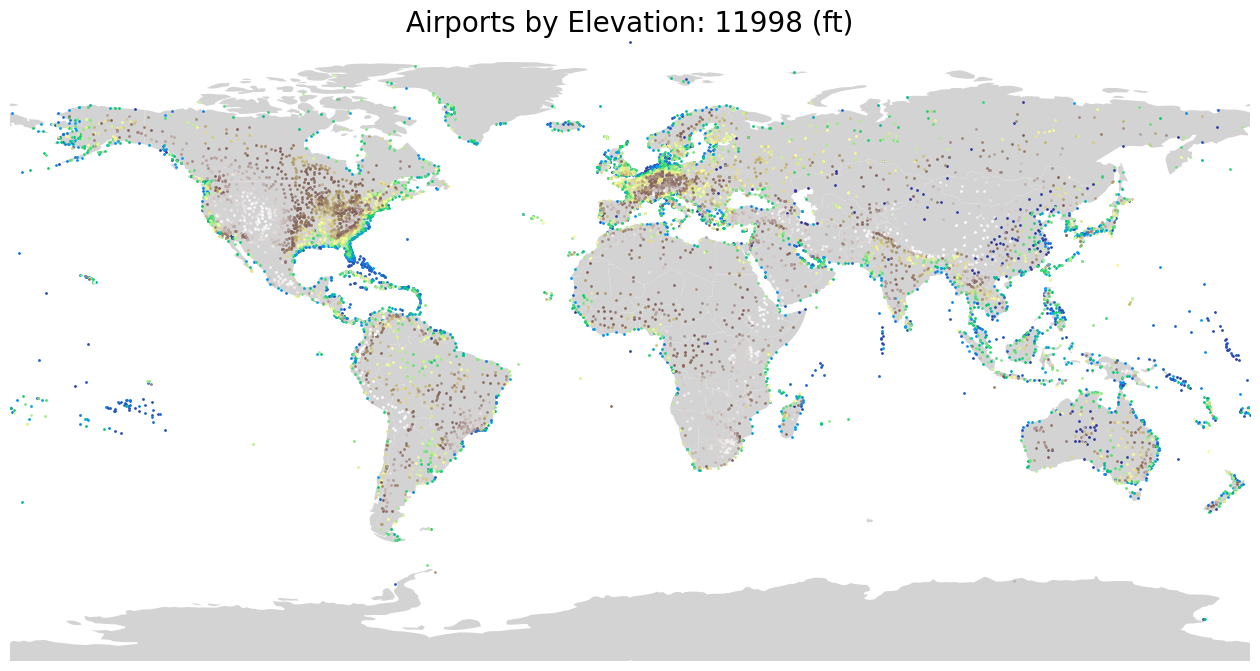

In [3]:
# plot

# Getting world map data from geo pandas
worldmap = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
fig = plt.figure(figsize=(16,9)) 

# Create axes
ax = fig.add_subplot(111)

ax.set_xlim([-180,180])
ax.set_ylim([-90,90])
ax.set_axis_off()

map = worldmap.plot(color="lightgrey", ax=ax)

frames = data.altitude_group.nunique()

# create a list of colors of size frames
colors = plt.cm.terrain(np.linspace(0, 1, frames))

for i in range(frames):
    data[data['altitude_group']==i].plot(x='longitude', y='latitude', kind='scatter',color =  colors[i],s=1, ax=ax)
    # get average altitude
    avg_altitude = data[data['altitude_group']==i]['altitude'].mean()
    plt.title(f'Airports by Elevation: {round(avg_altitude)} (ft)', fontsize=20)
    # 300 is good dpi, but for fast lets do 80
    plt.savefig(f'../Plots/Airports/{i}.jpg', bbox_inches='tight', pad_inches=0, dpi=200) 

In [5]:
# Create video
image_folder= '../Plots/Airports/'

# frames per second
fps=10

image_files = [os.path.join(image_folder,img)
               for img in os.listdir(image_folder)
               if img.endswith(".jpg")]

# sort images by number
image_files = sorted(image_files, key=lambda x: int(x.split('/')[-1].split('.')[0]))

# we then want to add about 5 seconds of the last frame
for i in range(5*fps):
    image_files.append(image_files[-1])


clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)

# resize to 1080p
clip_resized = clip.resize( (1920,1080) )

# add audio
audioclip = AudioFileClip("../Assets/Kevin MacLeod - Reaching Out.mp3")
clip_resized.audio = audioclip.set_duration(clip_resized.duration)

clip_resized.write_videofile('../Videos/airports.mp4')

Moviepy - Building video ../Videos/airports.mp4.
MoviePy - Writing audio in airportsTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video ../Videos/airports.mp4



Moviepy - Done !
Moviepy - video ready ../Videos/airports.mp4
